In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from read_db.CH import Getch
from scipy import stats

sns.set()

In [3]:
q = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-04' and '2022-04-10'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
'''

data = Getch(q, db='simulator_20220420').df

In [4]:
data.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [84]:
data.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


<AxesSubplot:xlabel='ctr', ylabel='Count'>

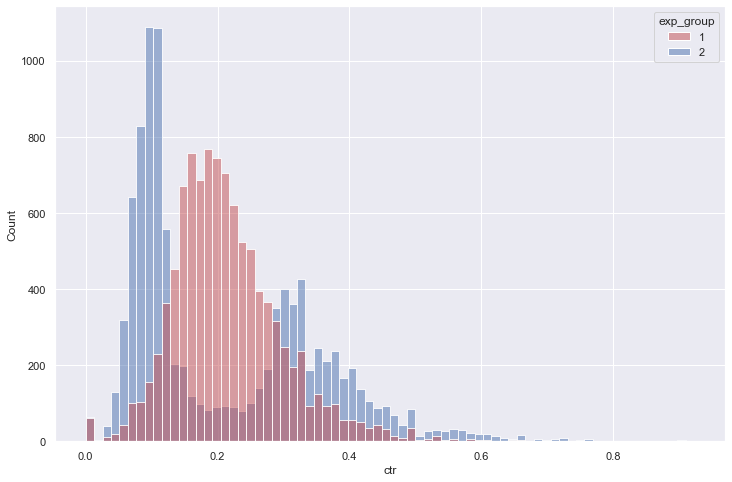

In [76]:
sns.set(rc={'figure.figsize':(12,8)})

sns.histplot(data=data, x='ctr', hue='exp_group', palette=['r', 'b'])

In [138]:
group1 = data[data['exp_group'] == 1].copy()
group2 = data[data['exp_group'] == 2].copy()

In [104]:
print(group1['ctr'].mean())
print(group2['ctr'].mean())

0.21560459841296287
0.21441927347479375


Согласно заданию проведем сравнение получившихся групп t тестом. Поскольку у второй группы распределение двугорбое и оно сильно не похоже на нормальное, при этом средие групп почти не отличаются. Не ожидаем от теста получить адекватных результатов. 

In [101]:
_, pval = stats.ttest_ind(group1['ctr'], group2['ctr'], equal_var=False)
print(f'Получившееся значение p value = {pval:.2f} > 0.05 не позволяет отвергнуть нулевую гипотезу о том, что средние в данных выборках равны')

Получившееся значение p value = 0.48 > 0.05 не позволяет отвергнуть нулевую гипотезу о том, что средние в данных выборках равны


Проведем сравнение выборок тестом Манна-Уитни

In [110]:
print(group1['ctr'].median())
print(group2['ctr'].median())

0.203125
0.1428571428571428


In [117]:
_, pval = stats.mannwhitneyu(group1['ctr'], group2['ctr'])
print(f'Получившееся значение p value = {pval:.2f} говорит о том, что между выборками есть значимое отличие')

Получившееся значение p value = 0.00 говорит о том, что между выборками есть значимое отличие


In [119]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [124]:
likes1 = group1['likes'].to_numpy()
views1 = group1['views'].to_numpy()
likes2 = group2['likes'].to_numpy()
views2 = group2['views'].to_numpy()

In [126]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

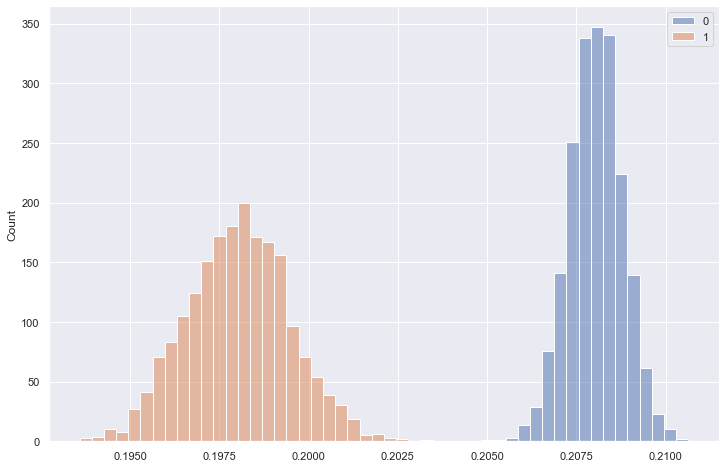

In [135]:
sns.histplot([ctr1, ctr2], bins=50)

<AxesSubplot:ylabel='Count'>

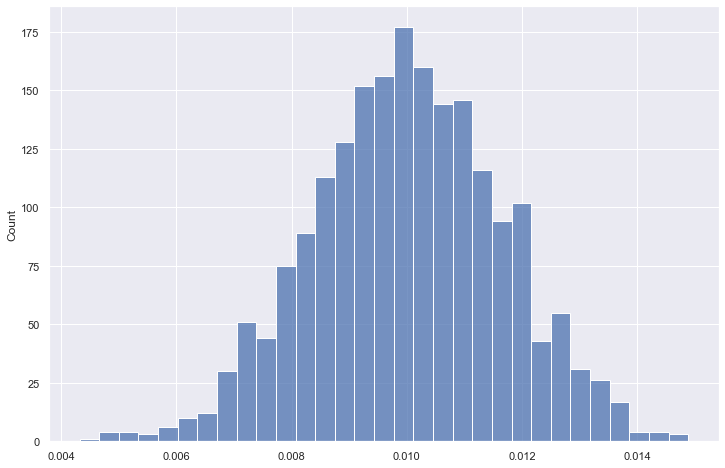

In [130]:
sns.histplot(ctr1 - ctr2)

Полученные бутстрапом гистограммы средних значений группового ctr показывают, что в контрольной группе групповой ctr выше.

Создадим сглаженный CTR для каждой группы и проведем тест на сравнение этой метрики между группами

In [62]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [139]:
global_ctr_1 = group1['ctr'].mean()
global_ctr_2 = group2['ctr'].mean()

group1['smoothed_ctr'] = group1.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group2['smoothed_ctr'] = group2.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

<AxesSubplot:ylabel='Count'>

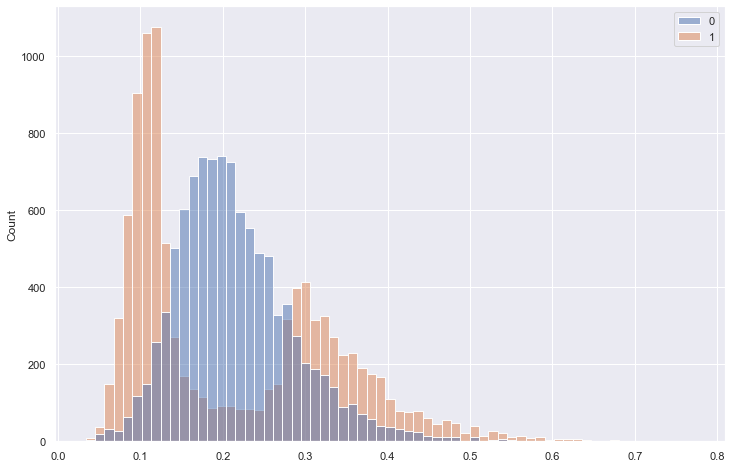

In [82]:
sns.histplot([group1['smoothed_ctr'].values, group2['smoothed_ctr'].values])

In [100]:
_, pval = stats.ttest_ind(group1['smoothed_ctr'], group2['smoothed_ctr'], equal_var=False)
print(f'Получившееся значение p value = {pval:.2f} > 0.05 не позволяет отвергнуть нулевую гипотезу о том, что средние в данных выборках равны')

Получившееся значение p value = 0.11 > 0.05 не позволяет отвергнуть нулевую гипотезу о том, что средние в данных выборках равны


In [105]:
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-04-04' and '2022-04-10'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

bucket_data = Getch(q, db='simulator_20220420').df

In [91]:
bucket_data.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

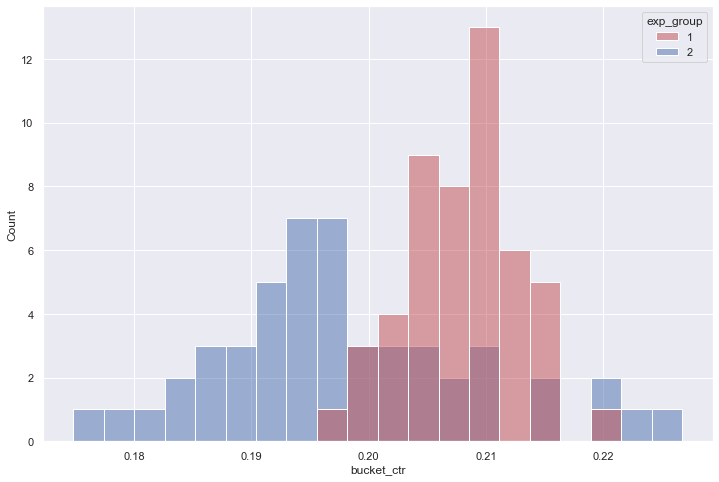

In [112]:
sns.histplot(data=bucket_data, x='bucket_ctr', hue='exp_group', palette=['r', 'b'], bins=20)

In [107]:
bucket_group1 = bucket_data[bucket_data['exp_group'] == 1]
bucket_group2 = bucket_data[bucket_data['exp_group'] == 2]

In [113]:
print(bucket_group1['bucket_ctr'].mean())
print(bucket_group2['bucket_ctr'].mean())

0.20812170724336013
0.19825944666552928


In [114]:
print(bucket_group1['bucket_ctr'].median())
print(bucket_group2['bucket_ctr'].median())

0.20870422646847037
0.19620940011426305


Проведем t тест над бакетным преобразованием

In [108]:
_, pval = stats.ttest_ind(bucket_group1['bucket_ctr'], bucket_group2['bucket_ctr'], equal_var=False)
print(f'Получившееся значение p value = {pval:.2f} < 0.05 позволяет отвергнуть нулевую гипотезу о том, что средние в данных выборках равны')

Получившееся значение p value = 0.00 < 0.05 позволяет отвергнуть нулевую гипотезу о том, что средние в данных выборках равны


Проведем тест Манна-Уитни над бакетным преобразованием

In [115]:
_, pval = stats.mannwhitneyu(bucket_group1['bucket_ctr'], bucket_group2['bucket_ctr'])
print(f'Получившееся значение p value = {pval:.2f} говорит о том, между выборками есть значимое отличие')

Получившееся значение p value = 0.00 говорит о том, между выборками есть значимое отличие


Были проведены статистические тесты на сравнение экспериментальной и контрольной группы.
- t тест Стюдента на сравнение этих групп, показал, что статистически значимых отличий между средними в этих группах нет. Но послькольку распределение в экспериментальной группе сильно отличалось от нормального и имело двугорбую форму, результаты данного теста некорректно использовать для принятия решения о наличии разницы в этих группах.
- Тест Манна-Уитни показал статистически значимые отличия между этими группами. И хотя данный тест не сравнивает медианы выборок, он более чувствителен к разнице между медианами, чем между среднеарифметическими значениями выборок. Поэтому значения этого теста отличаются от предыдущего. 

Гистограммы распределений группового ctr полученные бустрапом, показывают, что значения группового ctr в экспериментальной группе значимо ниже, чем в контрольной.

Далее была создана производная от ctr метрика — сглаженный ctr которая уменьшает зашумленность оригинальной метрики. Над ней также были проведены t тест Стьюдента и тест Манна-Уитни. Результаты таких тестов такие же как и выше, с несглаженной метрикой ctr

На последнем этапе AB теста над контрольной и экспериментальной группой было произведено бакетное преобразование. Группы были поделены на 50 бакетов с примерно 200 пользователями в каждой. Внутри каждого бакета был посчитал средний ctr и тесты проводились между группами по побакетным ctr'ам.
- Гистограмма распределения таких ctr'ов уже отличалась от оригинальной метрики. Пропал второй горб у экспериментальной выборки, хотя вместо него остался более толстый правый хвост. Также медиана экспериментальной группы стала ближе к тестовой.
- И t тест и тест Манна-Утни показывают значимые отличия между выборками
- Тесты над бакетным преобразованием работают лучше, но после такого преобразования скрывается истинная структура данных в выборках


Исходя из проведенного анализа, можно сказать, что алгоритм который выкатывали на данную группу пользователей, не слишком удачный. <br>
Большинство тестов показывают, что значения ctr в экспериментальной группе в среднем ухудшились.

Однако если изучать гистограмму распределения ctr пользователей с новым алгоритмом можно увидеть, что на ней двугорбое распределение, похожее на смесь двух нормальных распределений. Можно предположить, что новый рекомендательный алгоритм поделил пользователей на две подгруппы. Для одних пользователей он оказался лучше и их метрика ctr увеличилась, а для других — хуже и их ctr уменьшился. 

Следует тщателей изучить изучить экспериментальную группу, чем отличаются и что объединяет пользователей в этих подгруппах. Можно ли найти признаки по которым можно делить пользователей на такие подгруппы? 
